In [75]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler

# MAIN VERSION

In [76]:
# Read data
df = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_Main')
df['Risk Category'] = df['Risk Category'].ffill()
df = df.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
df['Risk ID'] = df['Risk ID'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Risk Category   105 non-null    object 
 1   Risk ID         105 non-null    object 
 2   Risk Indicator  105 non-null    object 
 3   Company         105 non-null    object 
 4   Value           101 non-null    float64
dtypes: float64(1), object(4)
memory usage: 4.2+ KB


In [77]:
list_reversed_indicators = ['1.02', '1.03', '2.01', '2.02', '2.03', '2.05', '3.01', '3.02', '3.03']

In [78]:
# Compute and store original min/max for each group
df['Original Min'] = df.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform('min')
df['Original Max'] = df.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform('max')

In [79]:
# Corrected scaling: Create a new scaler for each group and handle constant groups
df['Standardized Value'] = (
    df.groupby(['Risk Category', 'Risk Indicator'])['Value']
    .transform(lambda x: (
        # For constant groups, return 0 (or another default)
        np.full(len(x), 0) if x.nunique() == 1 
        # For non-constant groups, scale to [0, 100]
        else MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten() * 100
    ))
)

In [80]:
# Define a mask for rows to reverse (e.g., based on 'Risk ID')
mask = df['Risk ID'].isin(list_reversed_indicators)

# Reverse scaling using stored min/max and handle constant groups
df.loc[mask, 'Standardized Value'] = (
    # Invert scaling formula: (100 - Scaled) / 100 * (Min - Max) + Max
    (100 - df.loc[mask, 'Standardized Value']) / 100 * 
    (df.loc[mask, 'Original Min'] - df.loc[mask, 'Original Max']) + 
    df.loc[mask, 'Original Max']
)

# Handle constant groups (min == max): Set to original constant value
constant_mask = (df['Original Min'] == df['Original Max'])
df.loc[mask & constant_mask, 'Standardized Value'] = df.loc[mask & constant_mask, 'Original Min']

In [81]:
df[df.isna().any(axis=1)]

,Risk Category,Risk ID,Risk Indicator,Company,Value,Original Min,Original Max,Standardized Value
63,1. Hypercompetitive behavior,1.01,Valuation growth (%),x.AI,NaN,0.356217,1.400000e+01,NaN
65,1. Hypercompetitive behavior,1.03,Acceleration (yoy change in model updates freq...,x.AI,NaN,-0.439153,3.892183e+00,NaN
67,1. Hypercompetitive behavior,1.05,"Acquisitions - annual, cost",x.AI,NaN,0.000000,1.630000e+10,NaN
70,1. Hypercompetitive behavior,1.08,"Revenue growth rate (YoY, %)",x.AI,NaN,0.220000,3.570000e+00,NaN


In [82]:
df.to_csv("data/riskindicators_table_std.csv", index=False)

In [83]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_df = df.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

risk_category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       20 non-null     object 
 1   Company             20 non-null     object 
 2   Standardized Value  20 non-null     float64
dtypes: float64(1), object(2)
memory usage: 612.0+ bytes


In [84]:
risk_category_df

,Risk Category,Company,Standardized Value
0,1. Hypercompetitive behavior,Anthropic,24.542831
1,1. Hypercompetitive behavior,Google DeepMind,11.033785
2,1. Hypercompetitive behavior,Meta AI,18.843040
3,1. Hypercompetitive behavior,OpenAI,51.459255
4,1. Hypercompetitive behavior,x.AI,6.668647
5,2. ​Lack of compliance and safety practices,Anthropic,23.430314
6,2. ​Lack of compliance and safety practices,Google DeepMind,22.310558
7,2. ​Lack of compliance and safety practices,Meta AI,21.532571
8,2. ​Lack of compliance and safety practices,OpenAI,23.465266
9,2. ​Lack of compliance and safety practices,x.AI,0.152000


In [85]:
risk_category_df.to_csv("data/risk_category_std.csv", index=False)

In [86]:
# Aggregate the data by 'Company'
risk_company_df = df.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)
risk_company_df

,Company,Standardized Value
0,x.AI,5.834270
1,Google DeepMind,14.198777
2,Anthropic,16.456791
3,Meta AI,17.132852
4,OpenAI,46.783792


In [87]:
risk_company_df.to_csv("data/risk_company_std.csv", index=False)

In [88]:
# Sort the DataFrame by 'Standardized Value' in descending order
sorted_risk_company_df = risk_company_df.sort_values(by='Standardized Value', ascending=False)

# Create a table
table = go.Figure(data=[go.Table(
    header=dict(values=['Company', 'Risk Index'],
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[sorted_risk_company_df['Company'], sorted_risk_company_df['Standardized Value'].map('{:.2f}'.format)],
               fill_color='lavender',
               align='center'))
])

# Update the layout
table.update_layout(
    # title=None,
    autosize=False,
    width=500,
    height=200,
    margin=dict(l=10, r=10, t=40, b=0)
)

# Show the table
table.show()

In [89]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Standardized Value', 
        x=risk_company_df['Standardized Value'], 
        y=risk_company_df['Company'], 
        orientation='h',
        text=risk_company_df.index + 1,  # Add rank as text
        textposition='auto'
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    # title=None,
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=risk_company_df.index, ticktext=risk_company_df['Company']),
    template='plotly_white'
)

fig.show()

In [90]:
# Create a list of unique risk categories
companies = risk_category_df['Company'].unique()
categories = risk_category_df['Risk Category'].unique()


# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in companies:
    company_data = risk_category_df[risk_category_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=categories,
        connectgaps = True,
        fill='toself',
        name=company
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        )),
    showlegend=True,
    title="Risk Index based on Category"
)

fig.show()

In [91]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(companies), 
    subplot_titles=[f"{company}" for company in companies], 
    specs=[[{'type': 'polar'}] * len(companies)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(companies):
    company_data = risk_category_df[risk_category_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Standardized Value'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 100]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=3500,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company"
)

fig.show()


In [92]:
# from plotly.subplots import make_subplots

# # Create a subplot with 5 rows (one for each company) and 1 column
# fig = make_subplots(
#     rows=len(companies), 
#     cols=1, 
#     subplot_titles=[f"{company}" for company in companies], 
#     specs=[[{'type': 'polar'}]] * len(companies)
# )

# # Adjust the position of the subplot titles
# for annotation in fig['layout']['annotations']:
#     annotation['y'] += 0.02

# # Add a trace for each company in its respective subplot
# for i, company in enumerate(companies):
#     company_data = risk_category_df[risk_category_df['Company'] == company]
#     fig.add_trace(go.Scatterpolar(
#         r=company_data['Standardized Value'],
#         theta=company_data['Risk Category'],
#         connectgaps=True,
#         fill='toself',
#         name=company
#     ), row=i+1, col=1)

# # Update the layout
# for j in range(1, len(companies) + 1):
#     fig.update_layout(**{f'polar{j}': dict(
#         radialaxis=dict(
#             visible=True,
#             range=[0, 400]
#         ),
#         angularaxis=dict(
#             rotation=90
#         ))
#     })

# fig.update_layout(
#     height=1920,  # Adjust height as needed
#     showlegend=True,
#     # title="Risk Index based on Category for Each Company"
# )

# fig.show()


In [93]:
# Create a radar chart for each category
for category in categories:
    category_data = df[df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Standardized Value'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 100]
            )),
        showlegend=True,
        title=f"Radar Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )]
    )
    
    fig.show()

## Regressions

### Only components

In [94]:
import statsmodels.api as sm

# Pivot the data so that each company has its own row and each risk category becomes a column.
df_pivot = risk_category_df.pivot(index='Company', columns='Risk Category', values='Standardized Value')

# Rename the columns for clarity. The mapping is:
# "1. Competitive behavior/practice"  -> "Competitive"
# "2. ​Compliance and Safety Practices" -> "Safety"
# "3. Commitment to emerging standards" -> "Commitment"
# "4. Incidents"                        -> "Incidents"
rename_map = {
    "1. Hypercompetitive behavior": "Competitive",
    "2. ​Lack of compliance and safety practices": "Safety",
    "3. Lack of commitment to emerging standards": "Commitment",
    "4. Incidents": "Incidents"
}
df_pivot = df_pivot.rename(columns=rename_map)

# Display the pivoted data (optional)
print(df_pivot)

# Define the dependent variable (y) and independent variables (X)
y = df_pivot['Incidents']
X = df_pivot[['Competitive', 'Safety', 'Commitment']]

# Add a constant term to the independent variables (the intercept)
X = sm.add_constant(X)

# Run the OLS regression
model = sm.OLS(y, X).fit(cov_type='HC3')

# Print the summary which includes coefficients, standard errors, and p-values.
print(model.summary())


Risk Category    Competitive     Safety  Commitment   Incidents
Company                                                        
Anthropic          24.542831  23.430314    0.666667    1.388889
Google DeepMind    11.033785  22.310558    0.666667   21.329365
Meta AI            18.843040  21.532571    0.000000   20.634921
OpenAI             51.459255  23.465266    0.666667  100.000000
x.AI                6.668647   0.152000    0.000000   16.269841
                            OLS Regression Results                            
Dep. Variable:              Incidents   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                    0.1007
Date:                Sat, 22 Feb 2025   Prob (F-statistic):              0.949
Time:                        11:39:39   Log-Likelihood:                -21.047
No. Observations:                   5   AIC:                             50.09

c:\Users\madegde\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 5 samples were given.



In [95]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       feature       VIF
0        const  5.253900
1  Competitive  1.506966
2       Safety  1.997562
3   Commitment  1.880205


<Axes: xlabel='Risk Category', ylabel='Risk Category'>

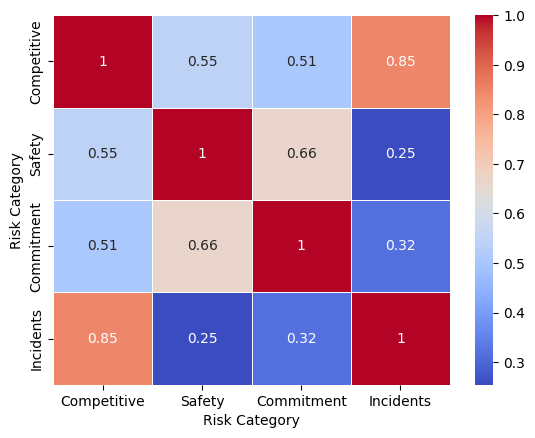

In [96]:
import seaborn as sns

# Compute the correlation matrix
corr = df_pivot.corr()

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=.5)

# RANK VERSION

In [97]:
rank_df = df.copy()
rank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Risk Category       105 non-null    object 
 1   Risk ID             105 non-null    object 
 2   Risk Indicator      105 non-null    object 
 3   Company             105 non-null    object 
 4   Value               101 non-null    float64
 5   Original Min        105 non-null    float64
 6   Original Max        105 non-null    float64
 7   Standardized Value  101 non-null    float64
dtypes: float64(4), object(4)
memory usage: 6.7+ KB


In [98]:
rank_df['Rank'] = rank_df.groupby(['Risk Category', 'Risk Indicator'])['Standardized Value'].rank(ascending=True, method='min')
rank_df

,Risk Category,Risk ID,Risk Indicator,Company,Value,Original Min,Original Max,Standardized Value,Rank
0,1. Hypercompetitive behavior,1.01,Valuation growth (%),Google DeepMind,0.356217,0.356217,1.400000e+01,0.000000,1.0
1,1. Hypercompetitive behavior,1.02,Market share (revenue),Google DeepMind,0.070000,0.009900,3.900000e-01,0.070000,4.0
2,1. Hypercompetitive behavior,1.03,Acceleration (yoy change in model updates freq...,Google DeepMind,3.892183,-0.439153,3.892183e+00,3.892183,4.0
3,1. Hypercompetitive behavior,1.04,"Acquisitions - annual, count",Google DeepMind,0.000000,0.000000,3.000000e+00,0.000000,1.0
4,1. Hypercompetitive behavior,1.05,"Acquisitions - annual, cost",Google DeepMind,0.000000,0.000000,1.630000e+10,0.000000,1.0
...,...,...,...,...,...,...,...,...,...
100,3. Lack of commitment to emerging standards,3.03,Endorsement of UN Global Digital Compact,OpenAI,0.000000,0.000000,0.000000e+00,0.000000,1.0
101,4. Incidents,4.01,AI-related incidents,OpenAI,30.000000,2.000000,3.000000e+01,100.000000,5.0
102,4. Incidents,4.02,Cybersecurity incidents (related to security/s...,OpenAI,2.000000,0.000000,2.000000e+00,100.000000,5.0
103,4. Incidents,4.03,Litigation Frequency where company is defendant,OpenAI,18.000000,0.000000,1.800000e+01,100.000000,5.0


In [99]:
rank_df.to_csv("data/riskindicators_table_rank.csv", index=False)

In [100]:
# Aggregate the data by 'Company' and 'Risk Category'
rank_cat_df = rank_df.groupby(['Risk Category', 'Company']).agg({'Rank': 'sum'}).reset_index()
rank_cat_df['Rank'] = rank_cat_df.groupby('Risk Category')['Rank'].rank(ascending=True, method='min')
rank_cat_df

,Risk Category,Company,Rank
0,1. Hypercompetitive behavior,Anthropic,3.0
1,1. Hypercompetitive behavior,Google DeepMind,4.0
2,1. Hypercompetitive behavior,Meta AI,2.0
3,1. Hypercompetitive behavior,OpenAI,5.0
4,1. Hypercompetitive behavior,x.AI,1.0
5,2. ​Lack of compliance and safety practices,Anthropic,5.0
6,2. ​Lack of compliance and safety practices,Google DeepMind,3.0
7,2. ​Lack of compliance and safety practices,Meta AI,2.0
8,2. ​Lack of compliance and safety practices,OpenAI,4.0
9,2. ​Lack of compliance and safety practices,x.AI,1.0


In [101]:
rank_cat_df.to_csv("data/risk_category_rank.csv", index=False)

In [102]:
# Aggregate the data by 'Company'
rank_company_df = rank_cat_df.groupby(['Company']).agg({'Rank': 'sum'}).reset_index()
rank_company_df['Rank'] = rank_company_df['Rank'].rank(ascending=True, method='min')
rank_company_df = rank_company_df.sort_values(by='Rank', ascending=True).reset_index(drop=True)
rank_company_df


,Company,Rank
0,x.AI,1.0
1,Meta AI,2.0
2,Anthropic,3.0
3,Google DeepMind,4.0
4,OpenAI,5.0


In [103]:
rank_company_df.to_csv("data/risk_company_rank.csv", index=False)

In [104]:
# Create a horizontal bar chart
fig = go.Figure(data=[
    go.Bar(
        name='Rank', 
        x=rank_company_df['Rank'], 
        y=rank_company_df['Company'], 
        orientation='h',
        text=rank_company_df.index + 1,  # Add rank as text
        textposition='auto'
    )
])

# Update the layout to remove x-axis and show y-axis with company names
fig.update_layout(
    title='Rank by Company',
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=True, tickmode='array', tickvals=rank_company_df.index, ticktext=rank_company_df['Company']),
    template='plotly_white'
)

fig.show()

In [105]:
# Create a list of unique risk categories
rank_cat = rank_cat_df['Risk Category'].unique()
rank_comp = rank_cat_df['Company'].unique()

# Create a radar chart
fig = go.Figure()

# Add a trace for each company
for company in rank_comp:
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=categories,
        connectgaps=True,
        fill='toself',
        name=company
    ))

# Update the layout
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        )
    ),
    showlegend=True,
    title="Risk Rank based on Category"
)

fig.show()

In [106]:
# Create a subplot with 1 row and multiple columns (one for each company)
fig = make_subplots(
    rows=1, 
    cols=len(rank_comp), 
    subplot_titles=[f"{company}" for company in rank_comp], 
    specs=[[{'type': 'polar'}] * len(rank_comp)]
)

# Add a trace for each company in its respective subplot
for i, company in enumerate(rank_comp):
    company_data = rank_cat_df[rank_cat_df['Company'] == company]
    company_data = company_data.replace({
        'Risk Category': {
            "1. Hypercompetitive behavior": "Hypercompetitive",
            "2. ​Lack of compliance and safety practices": "Unsafety",
            "3. Lack of commitment to emerging standards": "Lack of Commitment",
            "4. Incidents": "Incidents"
        }
    })
    fig.add_trace(go.Scatterpolar(
        r=company_data['Rank'],
        theta=company_data['Risk Category'],
        connectgaps=True,
        fill='toself',
        name=company
    ), row=1, col=i+1)

# Adjust the position of the subplot titles
for annotation in fig['layout']['annotations']:
    annotation['y'] += 0.1  

# Update the layout
for j in range(1, len(companies) + 1):
    fig.update_layout(**{f'polar{j}': dict(
        radialaxis=dict(
            visible=True,
            range=[0, 5]
        ),
        angularaxis=dict(
            rotation=90
        ))
    })

fig.update_layout(
    width=2000,  # Adjust width as needed
    showlegend=False,
    # title="Risk Index based on Category for Each Company"
)

fig.show()


In [107]:
# Create a radar chart for each category
for category in categories:
    category_data = rank_df[rank_df['Risk Category'] == category]
    
    fig = go.Figure()
    
    # Add a trace for each company
    for company in companies:
        company_data = category_data[category_data['Company'] == company]
        fig.add_trace(go.Scatterpolargl(
            r=company_data['Rank'],
            theta=company_data['Risk ID'],
            connectgaps=True,
            fill='toself',
            name=company
        ))

    # Update the layout to move the legend to the bottom
    fig.update_layout(
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        )
    )
    
    # Add annotations for Risk ID and Risk Indicator
    annotations = []
    for risk_id, risk_indicator in zip(category_data['Risk ID'].unique(), category_data['Risk Indicator'].unique()):
        annotations.append(f"{risk_id}: {risk_indicator}")
    
    # Update the layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 5]),
        angularaxis=dict(
            rotation=90
        )),
        showlegend=True,
        title=f"Rank Chart for {category}",
        annotations=[dict(
            x=1.0,
            y=1.1,
            xref="paper",
            yref="paper",
            showarrow=False,
            text="<br>".join(annotations),
            align="left"
        )]
    )
    
    fig.show()

# FULL VERSION

In [108]:
# Read data
data = pd.read_excel("data/riskindicators_table.xlsx", sheet_name='Clean_Index_Full')
data['Risk Category'] = data['Risk Category'].ffill()
data = data.melt(id_vars=['Risk Category', 'Risk ID','Risk Indicator'], var_name='Company', value_name='Value')
data['Risk ID'] = data['Risk ID'].astype(str)

# Compute and store original min/max for each group
data['Original Min'] = data.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform('min')
data['Original Max'] = data.groupby(['Risk Category', 'Risk Indicator'])['Value'].transform('max')

# Corrected scaling: Create a new scaler for each group and handle constant groups
data['Standardized Value'] = (
    data.groupby(['Risk Category', 'Risk Indicator'])['Value']
    .transform(lambda x: (
        # For constant groups, return 0 (or another default)
        np.full(len(x), 0) if x.nunique() == 1 
        # For non-constant groups, scale to [0, 100]
        else MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten() * 100
    ))
)

# Define a mask for rows to reverse (e.g., based on 'Risk ID')
mask = data['Risk ID'].isin(list_reversed_indicators)

# Reverse scaling using stored min/max and handle constant groups
data.loc[mask, 'Standardized Value'] = (
    # Invert scaling formula: (100 - Scaled) / 100 * (Min - Max) + Max
    (100 - data.loc[mask, 'Standardized Value']) / 100 * 
    (data.loc[mask, 'Original Min'] - data.loc[mask, 'Original Max']) + 
    data.loc[mask, 'Original Max']
)

# Handle constant groups (min == max): Set to original constant value
constant_mask = (data['Original Min'] == data['Original Max'])
data.loc[mask & constant_mask, 'Standardized Value'] = data.loc[mask & constant_mask, 'Original Min']

# Save to CSV
data.to_csv("data/riskindicators_table_full.csv", index=False)

In [109]:
# Aggregate the data by 'Company' and 'Risk Category'
risk_category_data = data.groupby(['Risk Category', 'Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()

# Save to CSV
risk_category_data.to_csv("data/risk_category_full.csv", index=False)

In [110]:
# Aggregate the data by 'Company'
risk_company_data = data.groupby(['Company']).agg({
    'Standardized Value': 'mean'
}).reset_index()
risk_company_data = risk_company_data.sort_values(by='Standardized Value', ascending=True).reset_index(drop=True)

# Save to CSV
risk_company_data.to_csv("data/risk_company_full.csv", index=False)